Frauenquote für Jede Fraktion
==========
Zunächst untersuchen wir wieviele Frauen in jeder Fraktion vertreten sind.

In [62]:
import pandas as pd
import pymysql.cursors
from SqlCommand import SqlCommand

cnx = pymysql.connect(user='root',
                      password='secret',
                      host='127.0.0.1',
                      charset='utf8mb4',
                      database='btplenar')

si = SqlCommand(cnx)

query = """SELECT rede.idrede, sitzung.sitzungsnr, tagesordnungspunkt.thema, COUNT(*) as Beifall,
(SELECT COUNT(*) 
FROM absatz 
LEFT JOIN rede as r
ON (r.idRede = Absatz.rede)
Where r.idRede = rede.idRede) AS Absätze
FROM Beifall
LEFT JOIN (Rede, MdB, Absatz, Mandat, Tagesordnungspunkt, sitzung, Fraktion) 
ON (Rede.idRede = Absatz.Rede 
AND beifall.Absatz = Absatz.idAbsatz
AND Tagesordnungspunkt.idTagesordnungspunkt = Rede.top
AND sitzung.idSitzung = Tagesordnungspunkt.sitzung
AND Rede.redner = MdB.idMdB
AND Mandat.wahlp = sitzung.wahlperiode
AND Mandat.MdB = MdB.idMdB
AND mandat.fraktion = Fraktion.idFraktion)
WHERE Rede.kurzintervention is null
AND Rede.antwort_kurzintervention is null
AND Tagesordnungspunkt.befragung = 0
AND mandat.bis is NULL
AND mandat.WAHLP = 19
AND rede.mitRolle is NULL
AND (SELECT COUNT(*) 
FROM absatz 
LEFT JOIN rede as r
ON (r.idRede = Absatz.rede)
Where r.idRede = rede.idRede) > 3
group by rede.idrede;"""

query2 = """SELECT rede.idrede, MdB.idmdb, MdB.Vorname, MdB.Nachname, mdb.geschlecht, absatz.text, absatz.idabsatz, fraktion.name_kurz, mandat.art, mdb.geburtsdatum,
SUM(LENGTH(absatz.text) - LENGTH(REPLACE(absatz.text, ' ', '')) + 1) as woerter,
SUM(LENGTH(absatz.text)) as stringlength, 
SUM(LENGTH(absatz.text)) / SUM(LENGTH(absatz.text) - LENGTH(REPLACE(absatz.text, ' ', '')) + 1) as avg_word_length
FROM absatz
LEFT JOIN (Rede, MdB, Mandat, Fraktion, Tagesordnungspunkt, sitzung) 
ON (Rede.idRede = Absatz.Rede 
AND Tagesordnungspunkt.idTagesordnungspunkt = Rede.top
AND sitzung.idSitzung = Tagesordnungspunkt.sitzung
AND Rede.redner = MdB.idMdB
AND Mandat.MdB = MdB.idMdB
AND fraktion.idfraktion = mandat.fraktion)
WHERE Rede.kurzintervention is null
AND Rede.antwort_kurzintervention is null
AND mandat.bis is NULL
AND mandat.wahlp = 19
AND rede.mitRolle is NULL
AND (SELECT COUNT(*) 
FROM absatz 
LEFT JOIN rede as r
ON (r.idRede = Absatz.rede)
Where r.idRede = rede.idRede) > 3
group by rede.idrede;"""


raw_data = si.query(query)
df = pd.DataFrame([raw_data[key] for key in raw_data])
df.dropna(inplace=True)
df['Beifall'] = df['Beifall'].apply(lambda x: x - 1)


raw_data = si.query(query2)
df2 = pd.DataFrame([raw_data[key] for key in raw_data])

df = df.merge(df2, left_on='idrede', right_on='idrede', how='outer')
df['woerter'] = df['woerter'].astype(int)

In [55]:
df.groupby(['geschlecht', 'art', 'name_kurz'])['idmdb'].agg('count').unstack().fillna('-')

name_kurz               AfD  CDU/CSU  FDP GRÜNE  LINKE    SPD fraktionslos
geschlecht art                                                            
männlich   Direktwahl     4    381.0    -     -    6.0   93.0            -
           Landesliste  178     18.0  151    68   69.0   97.0           10
weiblich   Direktwahl     -     62.0    -     3    4.0   33.0           11
           Landesliste   21     13.0   45   100   97.0  100.0            -

In [56]:
df.groupby(['geschlecht', 'name_kurz'])['Beifall'].agg(['sum','mean']).unstack().fillna('-').round(2)

sum                                                       \
name_kurz      AfD CDU/CSU     FDP   GRÜNE   LINKE     SPD fraktionslos   
geschlecht                                                                
männlich    1756.0  3439.0  1721.0  1082.0   911.0  2020.0          1.0   
weiblich     232.0   915.0   496.0  1768.0  1144.0  1464.0          6.0   

             mean                                                   
name_kurz     AfD CDU/CSU    FDP  GRÜNE  LINKE    SPD fraktionslos  
geschlecht                                                          
männlich     9.87    9.07  11.71  16.15  12.31  10.92         0.33  
weiblich    11.60   12.89  11.02  17.17  11.33  12.00         0.67

In [59]:
df['Beifall / Wort'] = df.apply(lambda x: x['Beifall'] / x['woerter'] * 100, axis=1)
df.groupby(['geschlecht', 'name_kurz'])['Beifall / Wort'].agg('mean').unstack().fillna('-').round(2)

name_kurz,AfD,CDU/CSU,FDP,GRÜNE,LINKE,SPD,fraktionslos
geschlecht,,,,,,,
männlich,1.51,1.25,1.89,2.57,1.92,1.64,0.09
weiblich,1.86,1.69,1.98,2.62,1.93,1.78,0.19


In [45]:
df.groupby(['geschlecht', 'name_kurz'])['woerter'].agg('sum').unstack().fillna('-').round(2)

name_kurz,AfD,CDU/CSU,FDP,GRÜNE,LINKE,SPD,fraktionslos
geschlecht,,,,,,,
männlich,72896,169340,86321,51134,41638,96635,26
weiblich,9412,40856,21273,87464,52986,67929,539


In [43]:
df.groupby(['geschlecht', 'name_kurz', 'sitzungsnr'])['Beifall'].agg('count').unstack().fillna('-').round(2)

sitzungsnr              1   2   3   4   7   8  9     11  12  14 ...  17  18  \
geschlecht name_kurz                                            ...           
männlich   AfD           1  12   7  10   9   5  1  10.0   7  12 ...   9   7   
           CDU/CSU       3  22  13  22  19  14  4  24.0  14  30 ...  23  13   
           FDP           4  10   5  10   7   3  2   9.0   5  10 ...   7   6   
           GRÜNE         -   8   4   5   4   2  1   1.0   4   4 ...   3   2   
           LINKE         1   8   1   7   3   2  -   6.0   2   6 ...   2   2   
           SPD           2  11   7  13   9   5  1  10.0   5  14 ...  14   7   
           fraktionslos  -   -   -   -   -   -  -   1.0   1   - ...   -   -   
weiblich   AfD           -   1   -   2   4   -  1   1.0   -   1 ...   2   -   
           CDU/CSU       -   6   2   3   5   1  -   3.0   2   7 ...   7   5   
           FDP           -   2   1   1   3   2  -   2.0   1   4 ...   5   -   
           GRÜNE         2   4   2   6   6   3  1   9.0   3   9 ...   6   4   
           LINKE         1   4   5   5   7   3  1   5.0   4   7 ...   8   4   
           SPD           -   7   2   4  10   4  1   8.0   4  11 ...   6   5   
           fraktionslos  -   -   -   1   -   1  1   2.0   -   3 ...   -   -   

sitzungsnr              19  20  21  23  26  27    29  30  
geschlecht name_kurz                                      
männlich   AfD           -  11   6  15  18   7  19.0   7  
           CDU/CSU       -  24  11  26  41  13  37.0  13  
           FDP           -  12   3  16  12   4  14.0   4  
           GRÜNE         -   3   1   8   7   2   3.0   2  
           LINKE         -   5   1   8   6   4   8.0   -  
           SPD           -  15   5  14  18   8  17.0   7  
           fraktionslos  -   -   -   -   -   -   1.0   -  
weiblich   AfD           -   1   -   3   1   -   2.0   1  
           CDU/CSU       2   9   2   5   3   2   7.0   -  
           FDP           -   2   2   2   6   3   5.0   2  
           GRÜNE         -  11   4   4   8   4  13.0   3  
           LINKE         -   8   4   8  11   2   8.0   5  
           SPD           -   8   4   8  11   5  17.0   3  
           fraktionslos  -   -   -   -   -   -   1.0   -  

[14 rows x 21 columns]

In [44]:
df.groupby(['geschlecht', 'name_kurz'])['Beifall'].agg('count').unstack().fillna('-')

name_kurz,AfD,CDU/CSU,FDP,GRÜNE,LINKE,SPD,fraktionslos
geschlecht,,,,,,,
männlich,179,382,148,67,74,187,3
weiblich,20,73,45,105,104,123,10


D:\Anaconda3\envs\btplenar_py34\lib\site-packages\pandas\core\series.py:2551: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)
D:\Anaconda3\envs\btplenar_py34\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count   mean    std   min    25%   50%    75%   max
name_kurz    geschlecht                                                     
AfD          männlich     68.0  51.87  12.05  27.0  45.75  51.5  59.00  77.0
             weiblich      9.0  48.78   9.87  39.0  44.00  46.0  48.00  73.0
CDU/CSU      männlich    135.0  49.56   9.23  25.0  43.00  50.0  55.00  75.0
             weiblich     33.0  49.61  10.23  29.0  41.00  52.0  57.00  66.0
FDP          männlich     53.0  45.72  10.82  25.0  38.00  45.0  52.00  77.0
             weiblich     16.0  42.31   9.89  28.0  34.25  42.0  48.50  60.0
GRÜNE        männlich     25.0  47.64   9.99  33.0  39.00  47.0  53.00  65.0
             weiblich     36.0  48.78    9.8  33.0  40.50  50.5  56.25  65.0
LINKE        männlich     29.0  49.52  10.82  27.0  42.00  49.0  56.00  70.0
             weiblich     30.0  50.67   8.22  35.0  44.25  52.5  56.75  66.0
SPD          männlich     64.0  50.56   9.03  30.0  44.00  51.0  58.00  68.0
             weiblich     53.0  50.45   9.87  31.0  46.00  51.0  56.00  68.0
fraktionslos männlich      1.0  42.00      -  42.0  42.00  42.0  42.00  42.0
             weiblich      1.0  42.00      -  42.0  42.00  42.0  42.00  42.0

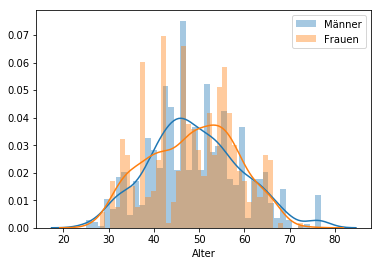

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

df['geburtsdatum'] = df['geburtsdatum'].apply(pd.to_datetime)
df['Alter'] = df['geburtsdatum'].apply(lambda x: (datetime.today() - x.to_datetime()).days/365.25).astype(int)

männer = df.where(df['geschlecht'] == 'männlich').dropna()
frauen = df.where(df['geschlecht'] == 'weiblich').dropna()

sns.distplot(männer['Alter'], bins=40)
sns.distplot(frauen['Alter'], bins=40)
plt.legend(['Männer', 'Frauen'])

(df[['geschlecht','idmdb','name_kurz','Alter']].drop_duplicates()
 .groupby(['name_kurz', 'geschlecht'])['Alter']
 .describe().round(2).fillna('-'))